# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
from google.colab import drive
drive.mount('/content/drive')

path = r'/content/drive/My Drive/ECE1512/ProjectB/'
import os
os.chdir(path)  # Change the directory to torchRay-master folder
import sys
sys.path.insert(0, path)

Mounted at /content/drive


In [2]:
!pip install keras-flops lime

     |████████████████████████████████| 275 kB 5.1 MB/s 
     |████████████████████████████████| 462 kB 46.5 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=3706f6f36a3819d166ce469891aecff2938556174f34b119b879aa5afcb39062
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [3]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from typing import Union
from keras_flops import get_flops
import numpy as np

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [4]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  class_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, class_labels

mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model creation

In [5]:
# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
cnn_model.add(tf.keras.layers.Conv2D(32, 3, strides=1, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=1))

cnn_model.add(tf.keras.layers.Conv2D(64, 3, strides=1, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))

cnn_model.add(tf.keras.layers.Flatten())

cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))

cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(10))


# Build fully connected student.
fc_model = tf.keras.Sequential()

# your code start from here for step 2
fc_model.add(tf.keras.layers.Flatten())

fc_model.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model.add(tf.keras.layers.Dense(784, activation='relu'))

fc_model.add(tf.keras.layers.Dense(10))

# Teacher loss function

In [6]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute class knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  class_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for classes.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(
      tf.losses.categorical_crossentropy(labels, class_logits, from_logits=True)
      )

  return cross_entropy_loss_value

# Student loss function

In [7]:
# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits = fc_model(images, training=True)

  # Compute class distillation loss between student class logits and
  # softened teacher class targets probabilities.

  # your code start from here for step 3
  teacher_class_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_class_logits, 
                                              student_class_logits, 
                                              DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(
      tf.losses.categorical_crossentropy(labels, student_class_logits, 
                                         from_logits=True))
  
  return ALPHA * cross_entropy_loss_value + (1 - ALPHA) * distillation_loss_value

# Train and evaluation

In [8]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn, if_eval=True):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    if if_eval is True:
      num_correct = 0
      num_total = builder.info.splits['test'].num_examples
      for images, labels in mnist_test:
        # your code start from here for step 4
        num_correct += compute_num_correct(model, images, labels)[0]
      print("Class_accuracy: " + '{:.2f}%'.format(
          num_correct / num_total * 100))


# Training models

In [9]:
# your code start from here for step 5 
# train_and_evaluate(cnn_model, compute_teacher_loss)
# cnn_model.save('./task1_teacher.h5')
cnn_model = tf.keras.models.load_model('./task1_teacher.h5')

In [10]:
# your code start from here for step 5 
train_and_evaluate(fc_model, compute_student_loss)

Epoch 1: Class_accuracy: 96.77%
Epoch 2: Class_accuracy: 97.80%
Epoch 3: Class_accuracy: 98.22%
Epoch 4: Class_accuracy: 98.31%
Epoch 5: Class_accuracy: 98.48%
Epoch 6: Class_accuracy: 98.52%
Epoch 7: Class_accuracy: 98.61%
Epoch 8: Class_accuracy: 98.62%
Epoch 9: Class_accuracy: 98.75%
Epoch 10: Class_accuracy: 98.68%
Epoch 11: Class_accuracy: 98.67%
Epoch 12: Class_accuracy: 98.74%


# Test accuracy vs. tempreture curve

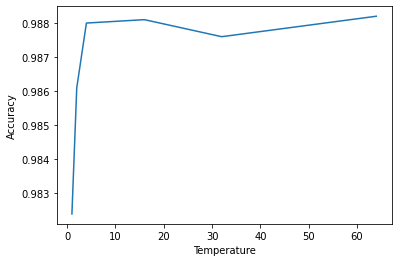

In [11]:
# your code start from here for step 6
Ts = [1, 2, 4, 16, 32, 64]
Accuracies = [0.9824, 0.9861, 0.9880, 0.9881, 0.9876, 0.9882]

plt.ylabel("Accuracy")
plt.xlabel("Temperature")
plt.plot(Ts, Accuracies)
plt.show()

# Train student from scratch

In [12]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7

fc_model_no_distillation.add(tf.keras.layers.Flatten())

fc_model_no_distillation.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(784, activation='relu'))

fc_model_no_distillation.add(tf.keras.layers.Dense(10))

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over classes, but does not perform class distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_class_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.reduce_mean(
      tf.losses.categorical_crossentropy(labels, student_class_logits, from_logits=True))
  
  return cross_entropy_loss

train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 96.86%
Epoch 2: Class_accuracy: 97.36%
Epoch 3: Class_accuracy: 97.57%
Epoch 4: Class_accuracy: 98.03%
Epoch 5: Class_accuracy: 97.79%
Epoch 6: Class_accuracy: 97.98%
Epoch 7: Class_accuracy: 97.80%
Epoch 8: Class_accuracy: 98.02%
Epoch 9: Class_accuracy: 98.06%
Epoch 10: Class_accuracy: 98.04%
Epoch 11: Class_accuracy: 98.09%
Epoch 12: Class_accuracy: 98.02%


# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [13]:
# your code start from here for step 8
print(f"Params for Teacher Model {cnn_model.count_params()}")
print(f"Params for Student Model {fc_model.count_params()}")
print(f"Flops for Teacher Model {get_flops(cnn_model, batch_size=BATCH_SIZE)}")
print(f"Flops for Student Model {get_flops(fc_model, batch_size=BATCH_SIZE)}")

Params for Teacher Model 1011466
Params for Student Model 1238730
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Flops for Teacher Model 5642766848


Flops for Student Model 633825792


# XAI method to explain models

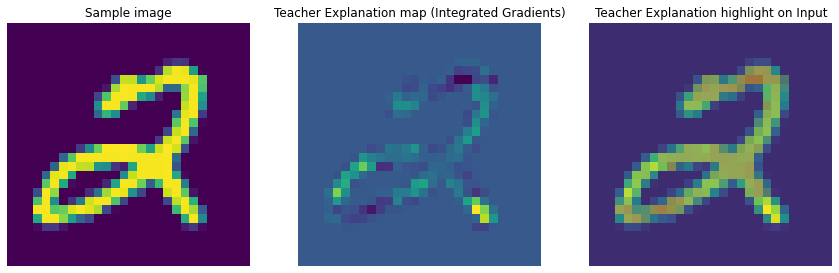

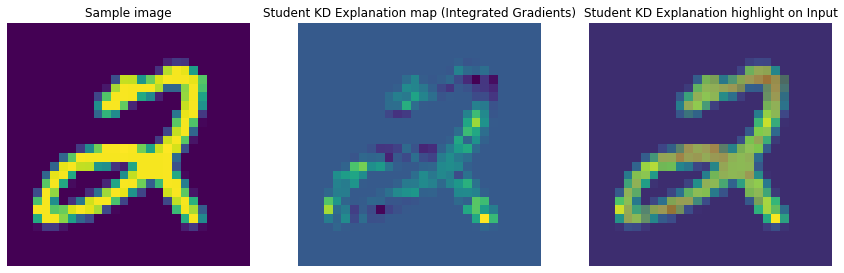

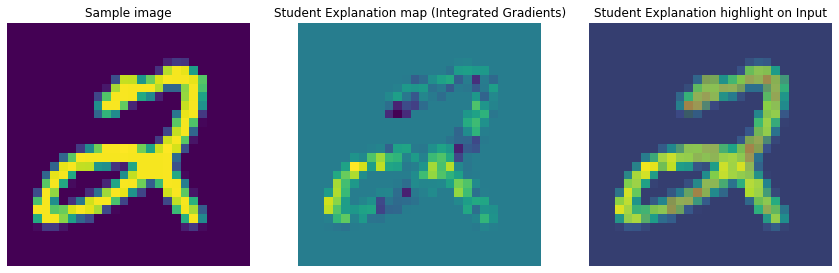

In [14]:
# your code start from here for step 9
from xai_custom import integrated_gradients
def XAI_Explain(model, model_name):
  for images, labels in mnist_test.take(1):
    explanation_map_IG = integrated_gradients(images[0], model, '3d', np.argmax(labels[0]), batch_size=BATCH_SIZE)
    explanation_map_IG -= explanation_map_IG.min()
    explanation_map_IG /= explanation_map_IG.max()+10e-30

    plt.figure(figsize=(20,5))

    plt.subplot(1,4,1)
    plt.imshow(images[0].numpy().squeeze(axis=2))
    plt.axis('off')
    plt.title('Sample image')

    plt.subplot(1,4,2)
    plt.imshow(explanation_map_IG.squeeze(axis=2))
    plt.axis('off')
    plt.title(f'{model_name} Explanation map (Integrated Gradients)')

    plt.subplot(1,4,3)
    plt.imshow(images[0].numpy().squeeze(axis=2))
    plt.imshow(explanation_map_IG.squeeze(axis=2), alpha=0.5)
    plt.axis('off')
    plt.title(f'{model_name} Explanation highlight on Input')

    plt.show()  

XAI_Explain(cnn_model, 'Teacher')
XAI_Explain(fc_model, 'Student KD')
XAI_Explain(fc_model_no_distillation, 'Student')

# Implementing the state-of-the-art KD algorithm

In [15]:
# your code start from here for step 13
fitnet = tf.keras.Sequential()

fitnet.add(tf.keras.layers.Flatten(name='flatten'))

fitnet.add(tf.keras.layers.Dense(784, activation='relu', name='dense1'))
fitnet.add(tf.keras.layers.Dense(784, activation='relu', name='guided'))

fitnet.add(tf.keras.layers.Dense(10, name='output'))
fitnet.build(input_shape=(BATCH_SIZE, 28, 28, 1))

In [16]:
cnn_model_hidden = tf.keras.models.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('dense').output)

fitnet_hidden = tf.keras.models.Model(inputs=fitnet.input, outputs=fitnet.get_layer('guided').output)
fitnet_regressor = tf.keras.layers.Dense(128)(fitnet_hidden.output)
fitnet_hidden = tf.keras.models.Model(inputs=fitnet_hidden.input, outputs=fitnet_regressor)

In [17]:
def compute_fitnet_hidden_loss(images, labels):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_hidden = fitnet_hidden(images, training=True)
  teacher_hidden = cnn_model_hidden(images, training=False)

  return tf.reduce_mean(tf.losses.mean_squared_error(student_hidden, teacher_hidden))

def compute_fitnet_loss(images, labels):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits = fitnet(images, training=True)
  # Compute class distillation loss between student class logits and
  # softened teacher class targets probabilities.

  teacher_class_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_class_logits, 
                                              student_class_logits, 
                                              DISTILLATION_TEMPERATURE)
  
  # Compute cross-entropy loss with hard targets.
  cross_entropy_loss_value = tf.reduce_mean(
      tf.losses.categorical_crossentropy(labels, student_class_logits, 
                                         from_logits=True))
  
  return ALPHA * cross_entropy_loss_value + (1 - ALPHA) * distillation_loss_value

In [18]:
train_and_evaluate(fitnet_hidden, compute_fitnet_hidden_loss, if_eval=False)

Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: 

In [19]:
for i, layer in enumerate(fitnet.layers):
  layer.set_weights(fitnet_hidden.layers[i + 1].get_weights())
  if layer.name == 'guided':
    break

train_and_evaluate(fitnet, compute_fitnet_loss)

Epoch 1: Class_accuracy: 98.61%
Epoch 2: Class_accuracy: 98.76%
Epoch 3: Class_accuracy: 98.81%
Epoch 4: Class_accuracy: 98.81%
Epoch 5: Class_accuracy: 98.84%
Epoch 6: Class_accuracy: 98.79%
Epoch 7: Class_accuracy: 98.83%
Epoch 8: Class_accuracy: 98.85%
Epoch 9: Class_accuracy: 98.82%
Epoch 10: Class_accuracy: 98.78%
Epoch 11: Class_accuracy: 98.90%
Epoch 12: Class_accuracy: 98.78%
